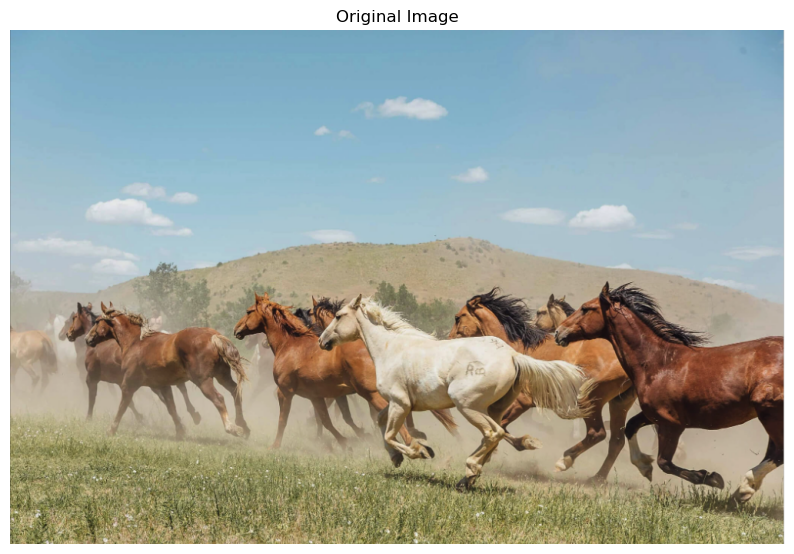

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def plot_images(images, titles, figure_size):
    plt.figure(figsize=(figure_size, figure_size))
    for i in range(len(images)):
        image = images[i]
        title = titles[i]
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')

def resize_to(image, target):
    target_height, target_width = target.shape[:2]
    image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    return image

def regenerate(org_image, masked_image, mask):
    inverse_mask = cv2.bitwise_not(mask)
    masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
    styled_masked = cv2.bitwise_and(masked_image, masked_image, mask=mask)
    return cv2.add(masked_original, styled_masked)    

image = cv2.imread('horses.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_images([image], ['Original Image'], 10)


In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device=torch.device('mps' if torch.cuda.is_available() else 'cpu')
print(device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

cpu


In [5]:
masks = mask_generator.generate(image)
print(masks[0].keys())

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


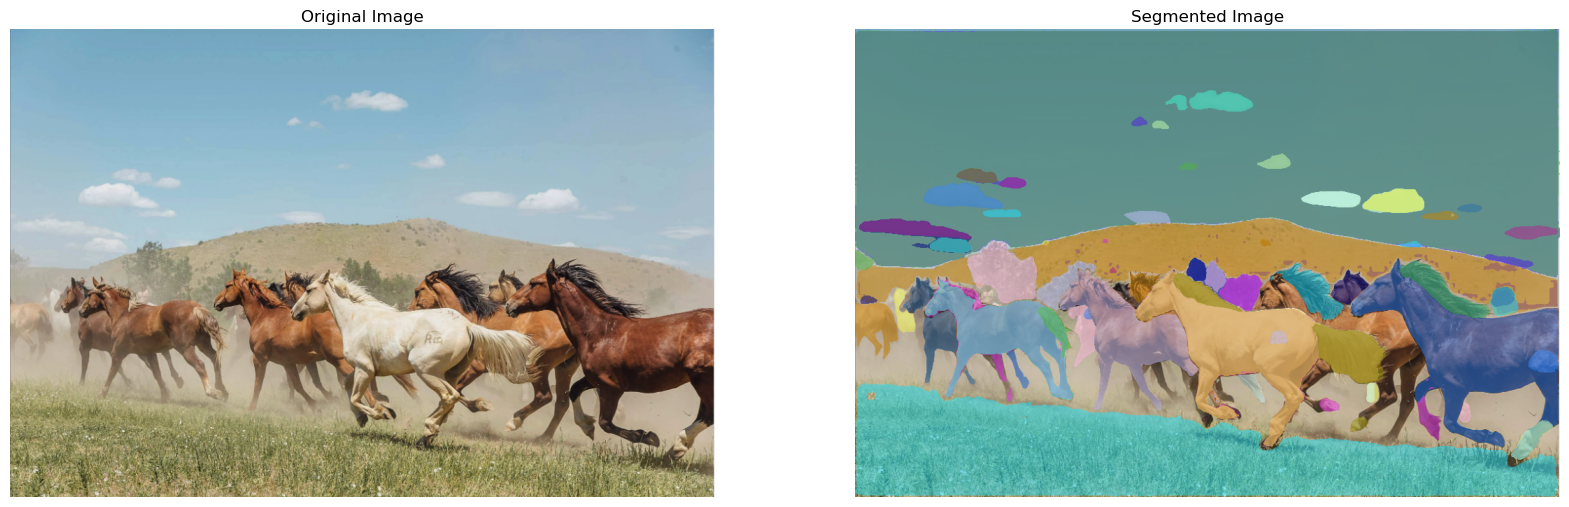

In [6]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
plot_images([image, annotated_image], ['Original Image', 'Segmented Image'], 20)

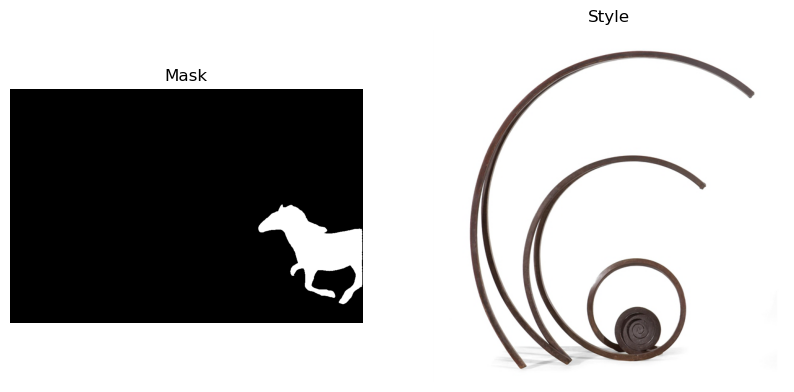

In [12]:
import os
import glob

linear_style_transfer_file = '/Users/ayberk.cansever/Documents/ECU/Thesis/LinearStyleTransfer/linearstyletransfer.py'
style_image_file = './styles/style-1.jpg'

org_image = cv2.imread('horses.png')
style_image = cv2.imread(style_image_file)

### sort masks according to area descendingly
sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)

segmented_masks = [
    mask['segmentation']
    for mask in sorted_masks
]

mask_index = 4;
mask = (segmented_masks[mask_index] * 255).astype(np.uint8) 
plot_images([cv2.cvtColor(mask, cv2.COLOR_BGR2RGB), cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)], ['Mask', 'Style'], 10)


# 1. Style and Mask

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


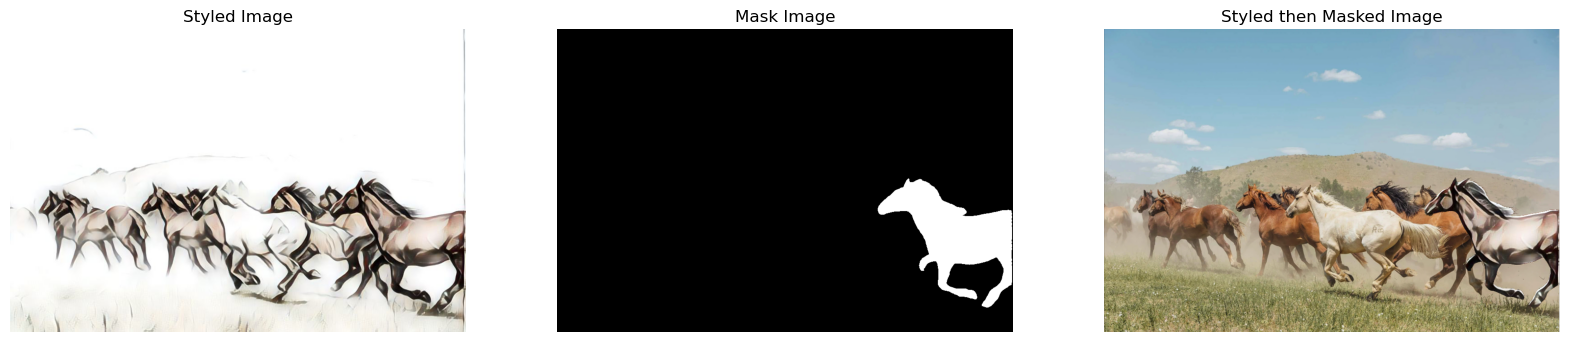

In [13]:
styled_image_file = './output/styled-0.png'
org_styled_image_file = './output/org-style-4.jpg'

### style the original image
os.system('python ' + linear_style_transfer_file + ' ' + 'horses.png' + ' ' + style_image_file + ' ' + org_styled_image_file)

### resize styled image to original size    
org_styled_image = resize_to(cv2.imread(org_styled_image_file), org_image)

### regenerating styled-masked image
final_styled_masked_image = regenerate(org_image, org_styled_image, mask)

### plot the images
mask_image_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
org_styled_image_rgb = cv2.cvtColor(org_styled_image, cv2.COLOR_BGR2RGB)
final_styled_masked_image_rgb = cv2.cvtColor(final_styled_masked_image, cv2.COLOR_BGR2RGB)

plot_images([org_styled_image_rgb, mask_image_rgb, final_styled_masked_image_rgb],
           ['Styled Image', 'Mask Image', 'Styled then Masked Image'],
           20)

# 2. Mask and Style

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


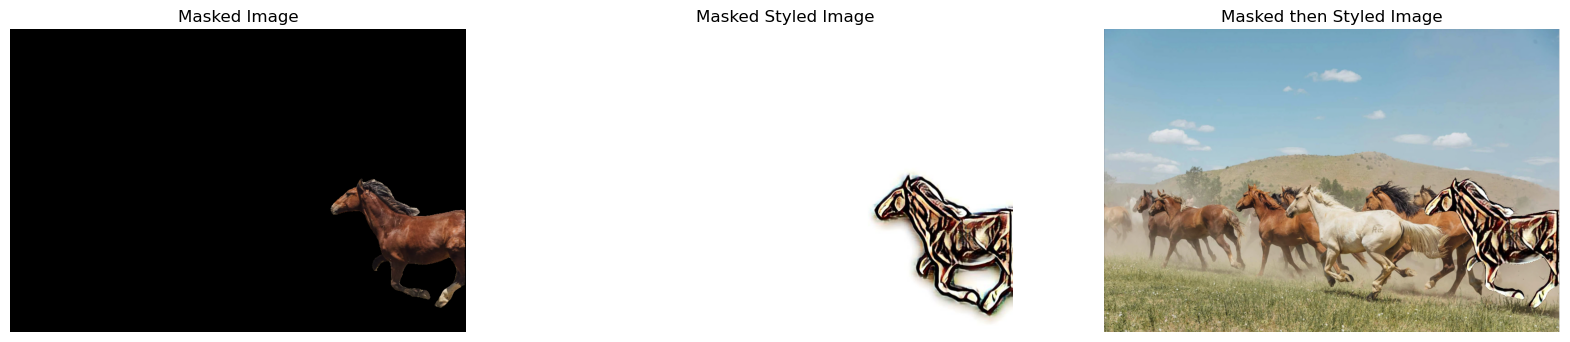

In [14]:
masked_image_file = './output/masked-4.jpg'
masked_styled_image_file = './output/masked-style-4.jpg'

### mask the original image
masked_image = cv2.bitwise_and(org_image, org_image, mask=mask)

### style the masked image
cv2.imwrite(masked_image_file, masked_image)
os.system('python ' + linear_style_transfer_file + ' ' + masked_image_file + ' ' + style_image_file + ' ' + masked_styled_image_file)

### resize styled image to original size    
masked_styled_image = resize_to(cv2.imread(masked_styled_image_file), org_image)

### regenerating masked-style image
final_masked_styled_image = regenerate(org_image, masked_styled_image, mask)

### plot the images
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
masked_styled_image_rgb = cv2.cvtColor(masked_styled_image, cv2.COLOR_BGR2RGB)
final_masked_styled_image_rgb = cv2.cvtColor(final_masked_styled_image, cv2.COLOR_BGR2RGB)

plot_images([masked_image_rgb, masked_styled_image_rgb, final_masked_styled_image_rgb],
           ['Masked Image', 'Masked Styled Image', 'Masked then Styled Image'],
           20)


# 3. Bounding-Boxed Masked and Styled

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


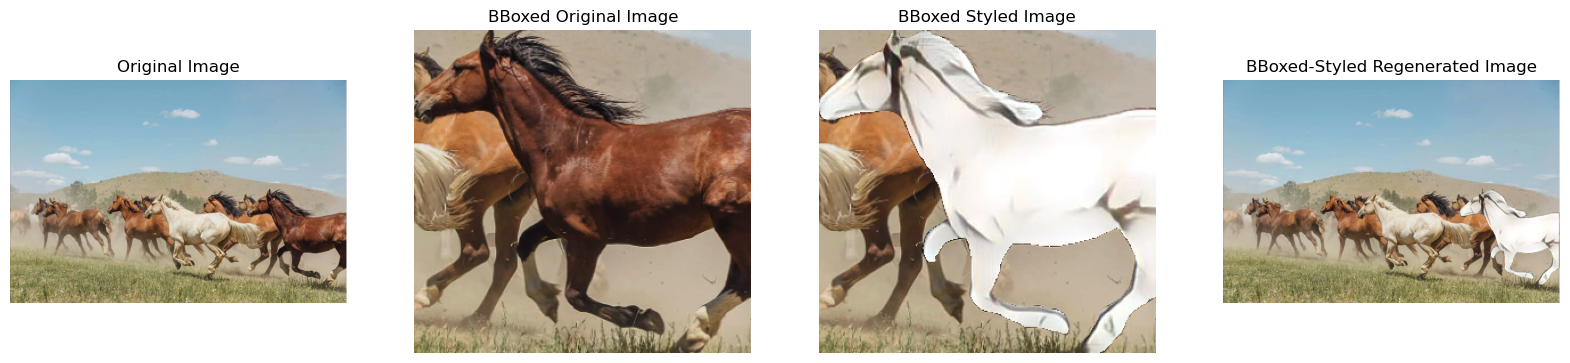

In [15]:
bboxed_image_file = './output/bboxed-masked-4.jpg'
bboxed_styled_image_file = './output/bboxed-masked-style-4.jpg'

org_image = cv2.imread('horses.png')
bbox = sorted_masks[mask_index]['bbox']

### bbox and mask the original image
x, y, w, h = bbox
bboxed_mask = mask[y:y+h, x:x+w]
original_bboxed_image = org_image[y:y+h, x:x+w]
masked_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=bboxed_mask)

### style the bboxed image
cv2.imwrite(bboxed_image_file, masked_bboxed_image)
os.system('python ' + linear_style_transfer_file + ' ' + bboxed_image_file + ' ' + style_image_file + ' ' + bboxed_styled_image_file)

### resize maasked styled image
bboxed_styled_image = cv2.imread(bboxed_styled_image_file)
bboxed_styled_image = cv2.resize(bboxed_styled_image, (w, h))
masked_styled_bboxed_image = cv2.bitwise_and(bboxed_styled_image, bboxed_styled_image, mask=bboxed_mask)

### regenerating bboxed styles original image
inverse_mask = cv2.bitwise_not(bboxed_mask)
masked_original_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=inverse_mask)
final_bboxed_masked_styled_image = cv2.add(masked_styled_bboxed_image, masked_original_bboxed_image) 

### inject styled bboxed image into original image
bbox_masked_styled_image = cv2.imread('horses.png')
bbox_masked_styled_image[y:y+h, x:x+w] = final_bboxed_masked_styled_image 

### plot the images
mask_image_rgb = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)
original_bboxed_image_rgb = cv2.cvtColor(original_bboxed_image, cv2.COLOR_BGR2RGB)
bboxed_styled_image_rgb = cv2.cvtColor(final_bboxed_masked_styled_image, cv2.COLOR_BGR2RGB)
bbox_masked_styled_image_rgb = cv2.cvtColor(bbox_masked_styled_image, cv2.COLOR_BGR2RGB)

plot_images([mask_image_rgb, original_bboxed_image_rgb, bboxed_styled_image_rgb, bbox_masked_styled_image_rgb],
           ['Original Image', 'BBoxed Original Image', 'BBoxed Styled Image', 'BBoxed-Styled Regenerated Image'],
           20)

# 4. Plot the Styled-Masked, Masked-Styled and BBoxed-Masked-Styled Images

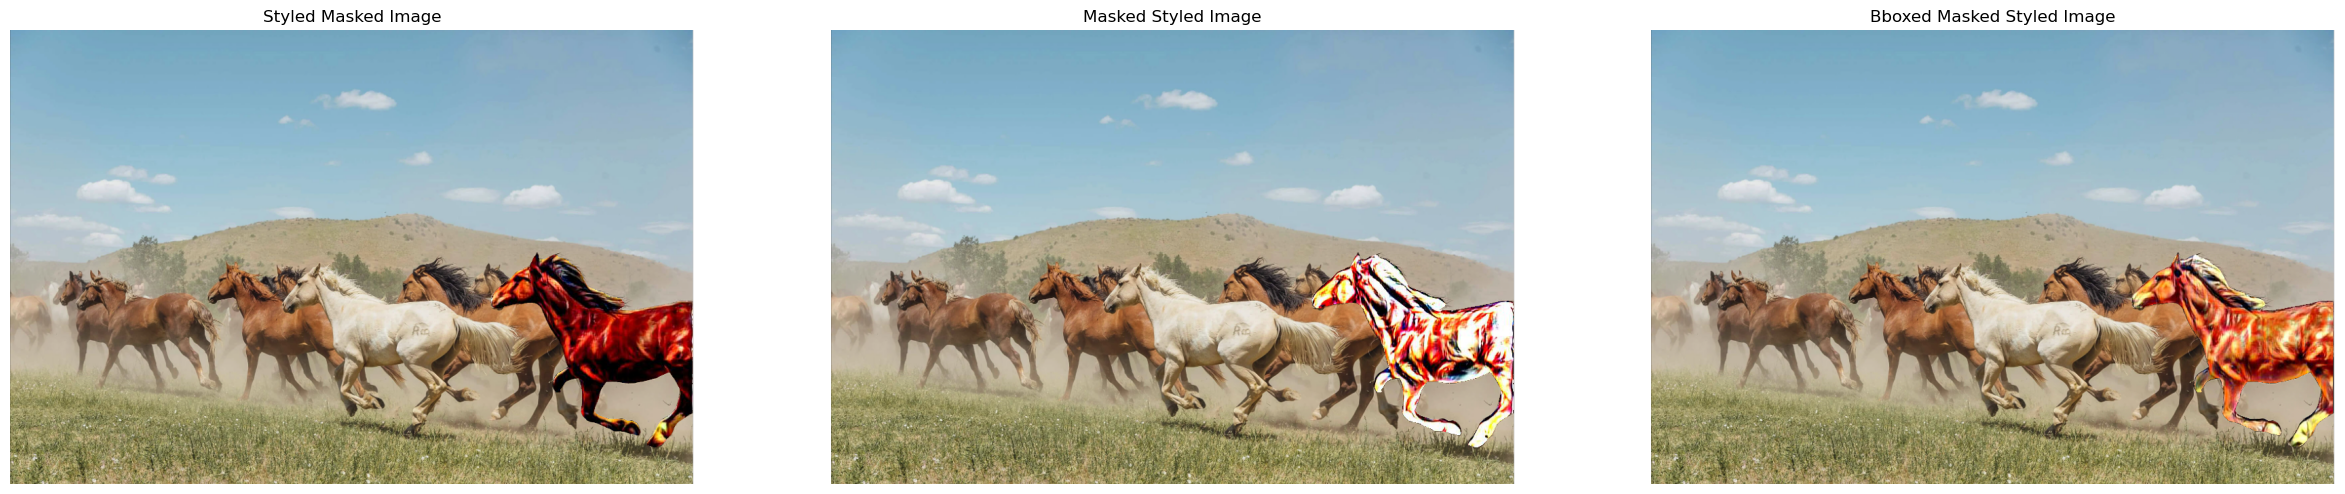

In [11]:
plot_images([final_styled_masked_image_rgb, final_masked_styled_image_rgb, bbox_masked_styled_image_rgb],
           ['Styled Masked Image', 'Masked Styled Image', 'Bboxed Masked Styled Image'],
           30)